In [4]:
import pickle
import pandas as pd
import json
import numpy as np

import sys, os
sys.path.append('../src/')
import load_data, utils

sys.path.append('../src/models/')
import fert_regression, yield_regression

In [2]:
# Set the path do data folders
path =  '../../Geo_data/'
path_econ = os.path.join(path, 'Crop_Eurasia/Economics', '')

if not os.path.exists(path_econ):
    os.makedirs(path_econ)

path_faostat = os.path.join(path, 'FAOSTAT', '')

# FAOSTAT file names
data_production = 'product_v7.csv'
data_area_arable = 'area_sums_v3.csv'
data_area_crops = 'area_v10.csv'
data_fertilizers = 'fert_v5.csv'

# Data from climate model
crop_changes = 'crops_disappear_2019_2026.txt'

In [3]:
# Define countries to consider
country_names = ['Japan', 'Kazakhstan', 
                'Myanmar', 'Philippines',
                'Korea', 'Turkey', 
                'Thailand', 'Uzbekistan', 
                'Viet Nam']

prefixes = ['JPN', 'KAZ', 
            'MMR', 'PHL',
            'KOR', 'TUR',
            'THA', 'UZB', 
            'VNM']

# Climate variables
vars  = ['pr','tmmx','tmmn']

# Crop variables
crops = ['Wheat', 'Maize', 'Soya', 'Rice']

# Fertilizer variables
fert = ['N', 'P2O5', 'K2O']

# Count countries
n_count = len(prefixes)

# Count months
n_months = 12

# Count features
n_feat = len(vars) * 2 * n_months + n_count*2 + len(crops)+ len(fert)

#### Load data

In [5]:
# Historical period
years = np.arange(1995, 2020)

# Future period
years_future = np.arange(2026, 2027)

In [6]:
# Clmate data both historical (TerraClimate) and future (CMIP5) withing country boundary
Climate = load_data.climate_for_yield(path, prefixes, country_names, vars, years, years_future, n_months)

In [259]:
import importlib

importlib.reload(load_data)

<module 'load_data' from 'c:\\Users\\Daria\\DT\\Geo\\ArableLand2\\notebooks\\../src\\load_data.py'>

In [7]:
# Crop area extracted from FAOSTAT
Total_area = load_data.arable_area(path_faostat, data_area_arable, data_area_crops, prefixes, country_names, years, crops)

# Fertilizers data from FAOSTAT
Fert = load_data.fertilizers(path_faostat, data_fertilizers, prefixes, country_names, years)

In [8]:
# Load expected negative crop changes from climate_lc model
neg_trend = json.load(open("crops_disappear_2019_2026.txt"))

In [247]:
# # Alternaively, load data from .pkl files
# with open('climate.pickle', 'wb') as handle:
#     pickle.dump(Climate, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('fert.pickle', 'wb') as handle:
#     pickle.dump(Fert, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('area.pickle', 'wb') as handle:
#     pickle.dump(Total_area, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # Load data from .pkl
# with open('climate.pickle', 'rb') as handle:
#     Climate = pickle.load(handle)

# with open('fert.pickle', 'rb') as handle:
#     Fert = pickle.load(handle)

# with open('area.pickle', 'rb') as handle:
#     Total_area = pickle.load(handle)

#### Fertilizers model

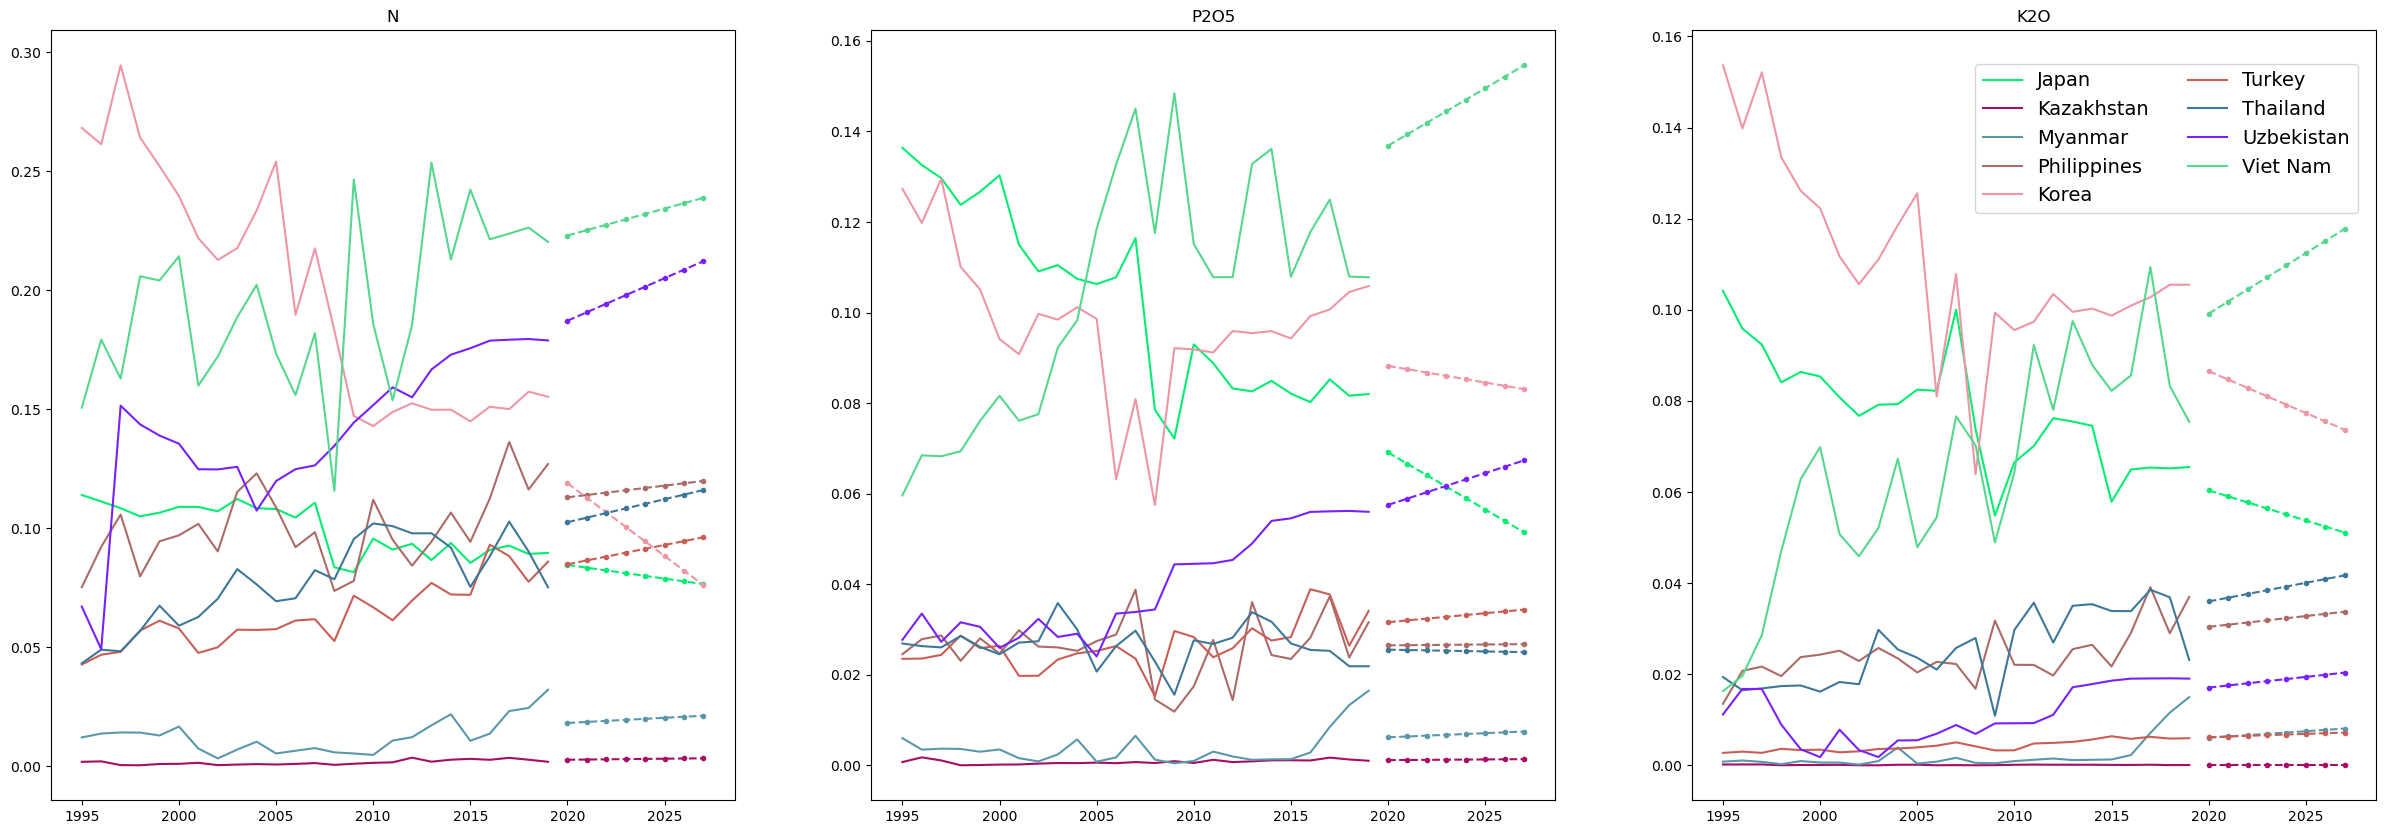

In [9]:
# Forecast fertilizers consumption based on statistics from FAOSTAT

years_future_fert = np.arange(2020, 2028)
Fert_future = fert_regression.model(Fert, Total_area,
                                    prefixes, country_names,
                                    years, years_future_fert)

#### Yield model

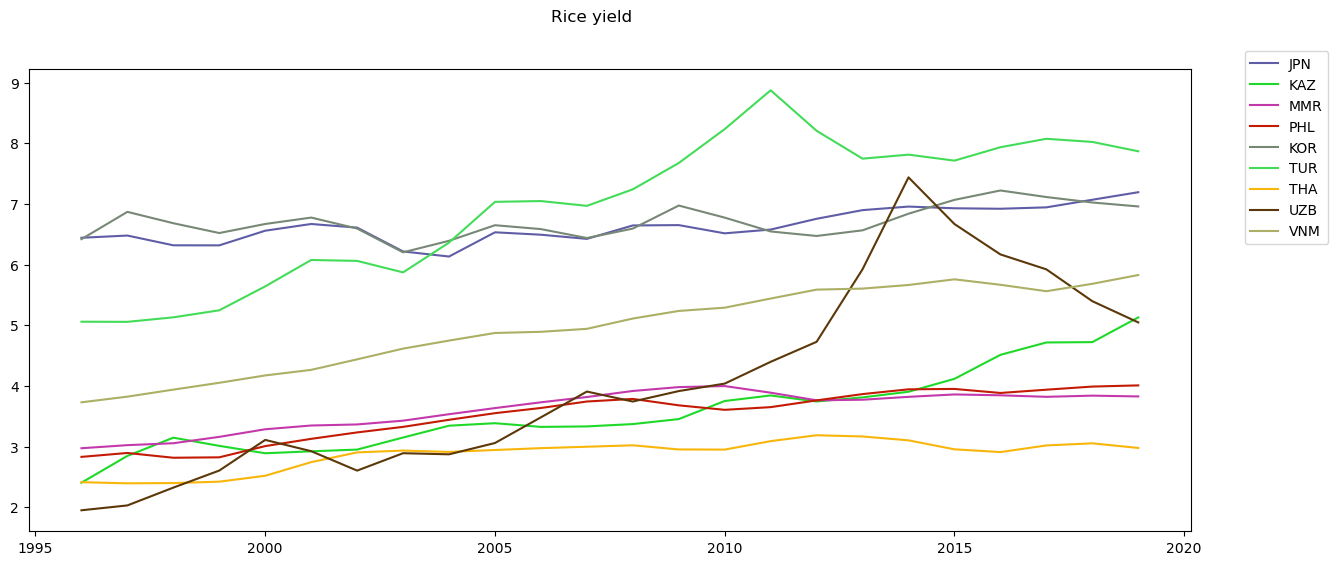

In [10]:
# Apply rolling mean to yield data
Yield = utils.yield_rolling_mean(path_faostat, data_production, 
                       prefixes, country_names, 
                       Total_area, years, window = 2)

In [11]:
# Collect data for train and test
X_train, Y_train, X_test, Y_test = utils.collect_data_yield(path_faostat, data_production, 
                                                            prefixes, country_names, 
                                                            Climate, Fert, Yield, 
                                                            Total_area, crops, vars, 
                                                            years, n_feat)

# Find data with rice as a crop
X_train_rice = X_train[X_train[:,-1]==1][:,:-4]
Y_train_rice = Y_train[X_train[:,-1]==1][:,0].astype(float)
X_test_rice = X_test[X_test[:,-1]==1][:,:-4]
Y_test_rice = Y_test[X_test[:,-1]==1][:,0].astype(float)
print('Rice #samples', X_train_rice.shape)

Rice #samples (198, 93)


In [12]:
# Set names of features
columns = []
for var in vars:
    for month in np.arange(1, n_months+1):
        columns.append(var + '_' + str(month))
        columns.append(var + '_' + str(month) + '_var')
for f in fert:
    columns.append(f)
for prefix in prefixes:
    columns.append('Trend_' + prefix)
for prefix in prefixes:
    columns.append(prefix)

df = pd.DataFrame(X_train_rice, columns = columns)
df.iloc[:5,:]

,pr_1,pr_1_var,pr_2,pr_2_var,pr_3,pr_3_var,pr_4,pr_4_var,pr_5,pr_5_var,...,Trend_VNM,JPN,KAZ,MMR,PHL,KOR,TUR,THA,UZB,VNM
0,4.842328,391.603333,3.924682,219.114761,9.909439,1289.429443,5.330798,488.361542,9.202442,1075.488647,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.445887,507.884308,3.901405,209.231903,6.649688,584.158569,9.026928,1219.824463,12.680779,2010.505005,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.951782,2856.069336,7.675245,953.471680,6.453110,569.612244,13.037421,2636.716064,15.457264,3355.376709,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.361329,323.597748,5.385763,405.437286,9.281306,1144.234375,9.176821,1185.017822,11.244739,1658.841675,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.570578,848.969788,3.622989,210.496872,7.975270,817.030457,10.898942,1473.250610,9.892322,1359.153076,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Collect future data
X_future = utils.collect_future_data(path_faostat, data_production,
                        prefixes, country_names,
                        Climate, Fert_future,
                        crops, vars,
                        years, years_future, n_feat)
X_future_rice = X_future[X_future[:,-1]==1][:,:-4]

#### XGBRegressor

In [14]:
# Regression model for yield prediction
from yield_regression import regression
xgbr =  regression()
xgbr.fit(X_train_rice, Y_train_rice)

# Calculate the scores
print('r2 on train data', xgbr.r2(X_train_rice, Y_train_rice))
print('r2 on test data', xgbr.r2(X_test_rice, Y_test_rice))

pred = xgbr.predict(X_test_rice)
print('MAPE on test data', xgbr.mape(pred, Y_test_rice))

r2 on train data 0.9999998853707417
r2 on test data 0.944170942653938
MAPE on test data 0.0567197461691252


In [15]:
# Pediction for future year
columns_df=['Country', 'Area_reduction', 'Prod_hist', 'Prod_future', 'Prod_ratio',  'Yield_hist', 'Yield_future', 'Yield_ratio']
prod_rice = pd.DataFrame(columns = columns_df)
n_coun = len(prefixes)
for i, prefix in enumerate(prefixes):
    prod_rice.loc[i,'Area_reduction'] = - neg_trend[prefix]

    # yield historical
    conditions = (Y_test[:,3] == '2018')&(Y_test[:, 2] == prefix)& (Y_test[:,4] =='Rice')
    prod_hist = float(Y_test[conditions][0,1])
    prod_rice.loc[i,'Country']=prefix
    prod_rice.loc[i,'Yield_hist']=float(Y_test[conditions][0,0])
    prod_rice.loc[i,'Prod_hist']=prod_hist

    # crop production in future
    X_future_rice_local = X_future_rice[X_future_rice[:,-n_coun+i]==1]
    yield_future = xgbr.predict(X_future_rice_local)
    pred_future = yield_future*Total_area[prefix][2019]['Rice']*(1-neg_trend[prefix]/100)
    prod_rice.loc[i,'Prod_future']=pred_future[0]
    prod_rice.loc[i,'Yield_future']=yield_future[0]

prod_rice['Prod_ratio'] = (prod_rice['Prod_future']  -  prod_rice['Prod_hist'])/ prod_rice['Prod_hist']*100
prod_rice['Yield_ratio'] = (prod_rice['Yield_future']  -  prod_rice['Yield_hist'])/ prod_rice['Yield_hist']*100

prod_rice

,Country,Area_reduction,Prod_hist,Prod_future,Prod_ratio,Yield_hist,Yield_future,Yield_ratio
0,JPN,-10.4,10390408.477842,9114298.414307,-12.281616,7.068305,6.919869,-2.100018
1,KAZ,-16.4,479142.058852,383260.096108,-20.011176,4.721542,4.495882,-4.779365
2,MMR,-3.2,27448532.295035,25500738.214087,-7.096168,3.839326,3.806417,-0.857138
3,PHL,-7.4,19148381.790169,16332768.564735,-14.704184,3.988909,3.791899,-4.938947
4,KOR,-6.5,5180825.100008,4572747.445356,-11.737081,7.0232,6.701213,-4.584623
5,TUR,-9.7,963691.155655,830491.264007,-13.821844,8.021602,7.275033,-9.306977
6,THA,-1.9,32513396.881997,25218092.399823,-22.437842,3.053491,2.619742,-14.205035
7,UZB,-2.4,227417.218807,375487.5,65.10953,5.396579,5.925801,9.806633
8,VNM,-11.9,43022757.362878,35168107.22413,-18.256966,5.682767,5.357064,-5.73142
